# The task is to explore lossy floating-point compression by manipulating the least significant mantissa bits. Follow the steps:

1. Generate a relevantly large number of floating-point numbers from three distributions (e.g. uniform, Gaussian, and exponential).
2. Implement a lossy compression function to zero out between 8 and 16 least significant bits of the mantissa.
3. Save both full-precision and compressed data to binary files.
4. Measure and compare on-disk file sizes to analyze storage savings achieved through compression.
5. Compare statistical parameters of the distributions before and after compression.
6. Compute Mean Squared Error between original and compressed data.
7. Plot original and compressed data to observe distribution changes.
8. Discuss optimal compression levels for different use cases (e.g., high-precision computing or limited storage resources).



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import struct
import os
import sys

N = 10**6

uniform_floating_point = np.random.uniform(0, 9, N).astype(np.float32)

# mean=0, standard deviation=1
gaussian_floating_point= np.random.normal(21, 5, N).astype(np.float32)

# lambda=1.0
exponential_floating_point = np.random.exponential(2.0, N).astype(np.float32)

print(type(uniform_floating_point[0]))
print(uniform_floating_point)
print(gaussian_floating_point)
print(exponential_floating_point)


<class 'numpy.float32'>
[1.6505104 5.2222133 3.4087703 ... 4.3544784 3.5548668 6.325191 ]
[15.044002 25.04362  26.24855  ... 27.267605 20.274546 23.221567]
[0.17518514 1.437631   2.1008976  ... 5.5462804  0.18187916 0.12426192]




## Function Descriptions

### `binary_list_to_bin(binary_list, filename):`
Saves **16-bit binary compressed data** to a file (`filename`).

### `float_list_to_bin(data, filename):`
Saves **data acquired from different distributions** in **Float32 format**.

### `num_to_16bit(fnum):`
Converts **Float32 to a 16-bit binary** representation.

### `get_file_size(filename):`
Returns the **size of a file** in bytes.

### `read_16bit_bin_as_float32(filename):`
Reads the **binary file saved by `binary_list_to_bin`** and converts it back to **Float32**.

### `plot_two_distributions(data1, data2, title1="Distribution 1", title2="Distribution 2"):`
Plots the **distribution of compressed and actual data side by side**.

### `mse(actual, pred):"`
Calculates the **Mean Squared Error (MSE)** between actual and compressed values.

### `def compare_statistics(actual, compressed, distribution_name="Distribution"):`
Calculates and compares **statistics** between actual and compressed values.

In [2]:
#Saves a list of 16-bit binary strings to a binary file.
def binary_list_to_bin(binary_list, filename ):
    with open(filename, "wb") as f:
        for binary_string in binary_list:
            byte_value = int(binary_string, 2).to_bytes(2, byteorder='big')  # Convert to 2 bytes
            f.write(byte_value)  # Write to file

#Saves a list of floats to a binary file.
def float_list_to_bin(data, filename):
    with open(filename, 'wb') as f:
        for x in data:
            f.write(struct.pack('f', x))

#========================================================================================================================================

def num_to_16bit(fnum):
    # converting float32 to 16 bit binary string
    res = struct.unpack('!I', struct.pack('!f', fnum))[0]
    a=f"{res:032b}"
    #zero out or removing 16 least significant bits of the mantissa.
    bit_string = a[:-16]
    return bit_string


#========================================================================================================================================
l=0
for j in (uniform_floating_point,gaussian_floating_point,exponential_floating_point):

    l_name=["uniform_floating_point","gaussian_floating_point","exponential_floating_point"]
    
    lossy_comp=[]
    for i in j:
        lossy_comp.append(num_to_16bit(i))
    
    float_list_to_bin(j, f'/Users/utkarshvashistha/Desktop/{l_name[l]}.bin')
    
    
    binary_list_to_bin( lossy_comp,f'/Users/utkarshvashistha/Desktop/{l_name[l]}_lossy_comp.bin')
    l=l+1



In [3]:
#Returns the size of a file in bytes.
def get_file_size(filename):
    return os.path.getsize(filename)

In [4]:

def read_16bit_bin_as_float32(filename):
    """Reads 16-bit binary values from a file and converts them to float32 by appending 16 zero bits."""
    float_values = []
    
    with open(filename, "rb") as f:
        while True:
            byte_value = f.read(2)  # Read 16 bits (2 bytes)
            if not byte_value:
                break  # Stop if end of file is reached
            
            # Convert 16-bit value to an integer
            int_value = int.from_bytes(byte_value, byteorder='big')
            
            # Shift left by 16 bits to append 16 zeros
            reconstructed_32bit = int_value << 16  # Append 16 zero bits
            
            # Convert to IEEE 754 float32
            float_value = struct.unpack('>f', struct.pack('>I', reconstructed_32bit))[0]
            float_values.append(float_value)
    
    return float_values



In [5]:
def plot_two_distributions(data1, data2, title1="Distribution 1", title2="Distribution 2"):
    """Plots two distributions side by side using Seaborn and Matplotlib."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create 1 row, 2 columns layout
    
    # Plot first distribution
    sns.histplot(data1, bins=50, kde=True, ax=axes[0], color='blue')
    axes[0].set_title(title1)
    axes[0].set_xlabel("Value")
    axes[0].set_ylabel("Frequency")
    axes[0].grid(True)
    
    # Plot second distribution
    sns.histplot(data2, bins=50, kde=True, ax=axes[1], color='red')
    axes[1].set_title(title2)
    axes[1].set_xlabel("Value")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True)

    plt.tight_layout()  # Adjust spacing
    plt.show()


In [6]:
def mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean()

In [7]:
import numpy as np
import scipy.stats as stats
import pandas as pd

def compare_statistics(actual, compressed, distribution_name="Distribution"):
    
    metrics = {
        "Mean": [np.mean(actual), np.mean(compressed)],
        "Standard Deviation": [np.std(actual), np.std(compressed)],
        "Minimum": [np.min(actual), np.min(compressed)],
        "Maximum": [np.max(actual), np.max(compressed)],
        "Median": [np.median(actual), np.median(compressed)],
        "Skewness": [stats.skew(actual), stats.skew(compressed)],
        "Kurtosis": [stats.kurtosis(actual), stats.kurtosis(compressed)]
    }
    

    stats_df = pd.DataFrame(metrics, index=["Actual", "Compressed"])

    return stats_df


Before compression 4000000
After compression 2000000
Mean Squared Error 8.800181206789988e-05
                Mean  Standard Deviation   Minimum    Maximum    Median  \
Actual      2.001658            2.002136  0.000003  28.943575  1.387794   
Compressed  1.996021            1.996503  0.000003  28.875000  1.382812   

            Skewness  Kurtosis  
Actual      2.013002  6.170378  
Compressed  2.013079  6.171497  


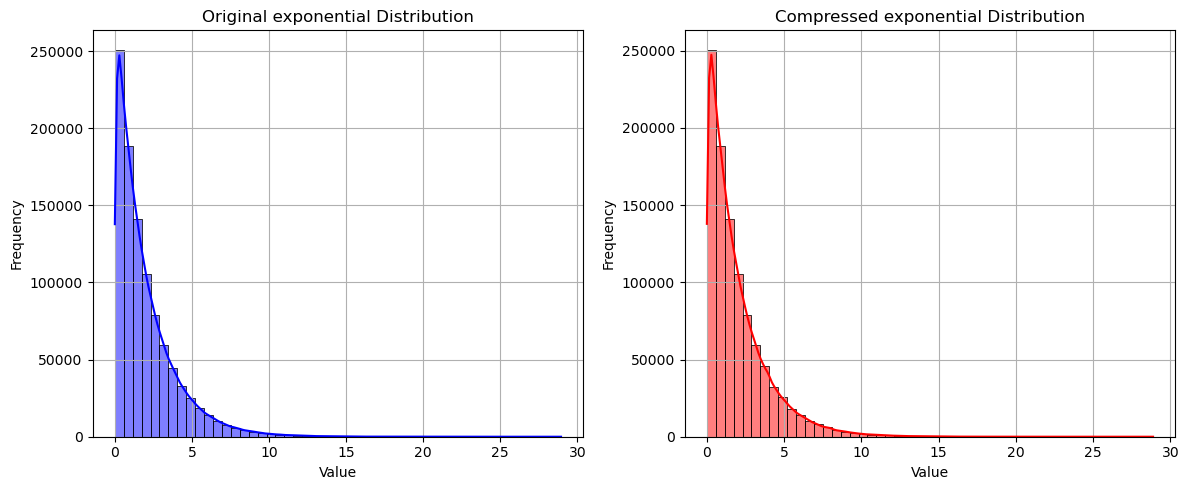

In [8]:
#EXPONENTIAL
filename = '/Users/utkarshvashistha/Desktop/exponential_floating_point_lossy_comp.bin'
exponential_compressed_values = read_16bit_bin_as_float32(filename)


print("Before compression",get_file_size('/Users/utkarshvashistha/Desktop/exponential_floating_point.bin'))
print("After compression",get_file_size('/Users/utkarshvashistha/Desktop/exponential_floating_point_lossy_comp.bin'))
print('Mean Squared Error',mse(exponential_floating_point,exponential_compressed_values))


print(compare_statistics(exponential_floating_point, exponential_compressed_values, "Exponential"))



plot_two_distributions(exponential_floating_point,exponential_compressed_values, 
                       title1="Original exponential Distribution", 
                       title2="Compressed exponential Distribution")

Before compression 4000000
After compression 2000000
Mean Squared Error 0.004782473884340267
                 Mean  Standard Deviation   Minimum    Maximum     Median  \
Actual      20.995398            5.000057 -6.089395  44.737164  20.993015   
Compressed  20.937170            4.990209 -6.062500  44.500000  20.875000   

            Skewness  Kurtosis  
Actual      0.004606 -0.003158  
Compressed  0.006684 -0.010823  


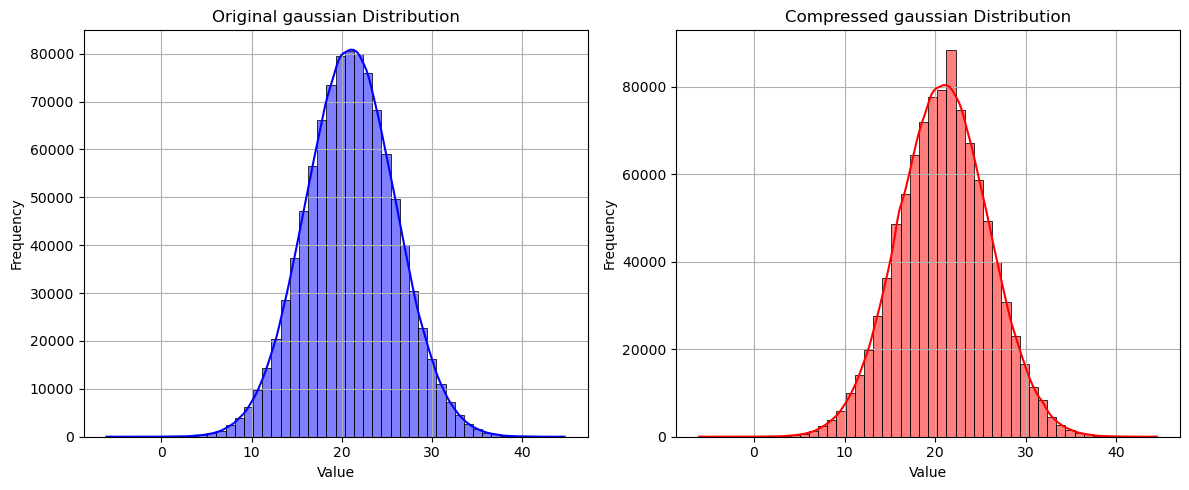

In [9]:
#GAUSSIAN
filename = '/Users/utkarshvashistha/Desktop/gaussian_floating_point_lossy_comp.bin'
gaussian_compressed_values = read_16bit_bin_as_float32(filename)

print("Before compression",get_file_size('/Users/utkarshvashistha/Desktop/gaussian_floating_point.bin'))
print("After compression",get_file_size('/Users/utkarshvashistha/Desktop/gaussian_floating_point_lossy_comp.bin'))
print('Mean Squared Error',mse(gaussian_floating_point,gaussian_compressed_values))

print(compare_statistics(gaussian_floating_point, gaussian_compressed_values, "Gaussian"))

plot_two_distributions(gaussian_floating_point, gaussian_compressed_values,
                       title1="Original gaussian Distribution", 
                       title2="Compressed gaussian Distribution")


Before compression 4000000
After compression 2000000
Mean Squared Error 0.0003092534307436563
                Mean  Standard Deviation   Minimum   Maximum    Median  \
Actual      4.500242            2.595490  0.000005  8.999982  4.499089   
Compressed  4.487522            2.587856  0.000005  8.937500  4.468750   

            Skewness  Kurtosis  
Actual     -0.000039 -1.198509  
Compressed -0.000986 -1.200390  


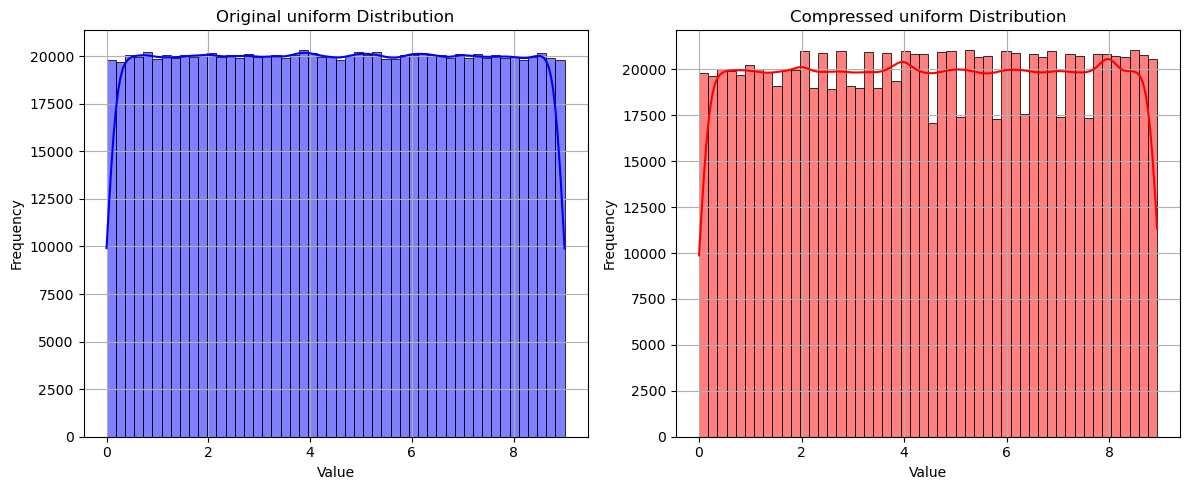

In [10]:
#UNIFORM
filename = '/Users/utkarshvashistha/Desktop/uniform_floating_point_lossy_comp.bin'
uniform_compressed_values = read_16bit_bin_as_float32(filename)


print("Before compression",get_file_size('/Users/utkarshvashistha/Desktop/uniform_floating_point.bin'))
print("After compression",get_file_size('/Users/utkarshvashistha/Desktop/uniform_floating_point_lossy_comp.bin'))
print('Mean Squared Error', mse(uniform_floating_point,uniform_compressed_values))


print(compare_statistics(uniform_floating_point, uniform_compressed_values, "Uniform"))



plot_two_distributions( uniform_floating_point, uniform_compressed_values,
                       title1="Original uniform Distribution", 
                       title2="Compressed uniform Distribution")